In [1]:
! pip install -q transformers

In [2]:
from transformers import pipeline

model = "facebook/sam-vit-base"
mask_generator = pipeline(model=model, task="mask-generation", points_per_batch = 32, device=0)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
from PIL import Image
import requests

img_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/bee.jpg"
image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")

In [4]:
masks = mask_generator(image, points_per_batch=32)

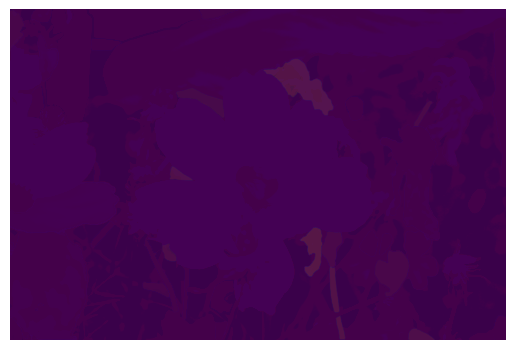

In [5]:
import matplotlib.pyplot as plt

plt.imshow(image, cmap='gray')

for i, mask in enumerate(masks["masks"]):
    plt.imshow(mask, cmap='viridis', alpha=0.1, vmin=0, vmax=1)

plt.axis('off')
plt.show()

# Without pipeline - Inference

In [6]:
from transformers import SamModel, SamProcessor
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [7]:
# bounding box around the bee
box = [2350, 1600, 2850, 2100]

inputs = processor(
        image,
        input_boxes=[[[box]]],
        return_tensors="pt"
    ).to("cuda")

with torch.no_grad():
    outputs = model(**inputs)

mask = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(),
    inputs["original_sizes"].cpu(),
    inputs["reshaped_input_sizes"].cpu()
)[0][0][0].numpy()

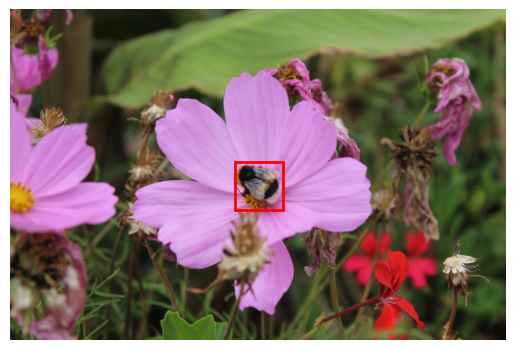

In [8]:
import matplotlib.patches as patches

fig, ax = plt.subplots()
ax.imshow(image)

rectangle = patches.Rectangle((2350, 1600), 500, 500, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rectangle)
ax.axis("off")
plt.show()